In [9]:
%load_ext autoreload
%autoreload

import pandas as pd
import sys
import numpy as np
import pickle as pkl
import time
import matplotlib.pyplot as plt

sys.path.append('../scripts')
import Baseline_classifiers as bc
from Classifier import Classifier
import ml_helper as mlh
import ml_evaluation as mle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Baseline Klassifikatoren

#### Error Rate

Die gewählte Metrik zum Vergleich der Klassifikatoren ist die sogenannte **Fehlerrate (Error Rate)**

$$
E = \frac{F}{G}
$$

- $F$: Absolute Anzahl falsch klassifizierter Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

- $G$: Gesamtanzahl der zu klassifizierenden Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

(nimmt Werte zwischen 0 (keine Fehler) <br>
und 1 (ausschließlich Fehler) an)


#### Accuracy

Die Accuracy steht der Fehlerrate gegenüber und gibt den Anteil an richtigen Klassifizierungen an.

(nimmt Werte zwischen 0 (alles falsch) <br>
und 1 (alles richtig) an)

$$
Accuracy = \frac{T}{G} = 1 - E = 1 - \frac{F}{G}
$$

- $T$: Absolute Anzahl richtig klassifizierter Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus

- $G$: Gesamtanzahl der zu klassifizierenden Aminosäuren <br>
über alle Sequenzen eines betrachteten Organismus


#### Berechnung der Error Rate

Berechnung der zu erwartenden Fehlerrate in Bezug auf alle Sequenzen eines bestimmten Organismus:

(Bei vorgegebener Wahrscheinlichkeitsverteilung)

$$
E = 1 - Accuracy = 1 - \frac{T}{G} = 1 - \frac{1}{G} \times \sum_{a \in A} \sum_{c\{a\} \in C\{a\}} (G_{c\{a\}} \times p_{c\{a\}})
$$

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

$T_{c\{a\}}$

## Datenvorbereitung

In [3]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]

dfs = {}
usage_biases = {}

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

for organism in organisms:
    dfs[organism] = pd.read_pickle(f"../data/{organism}/cleanedData.pkl")
    dfs[organism]['codons'] = dfs[organism]['sequence'].apply(group_codons)
    usage_biases[organism] = pd.read_pickle(f"../data/{organism}/usageBias.pkl")

display(dfs[organisms[0]].head())
display(usage_biases[organisms[0]])

,id,description,sequence,translation,seguid,codons
3847,lcl|U00096.3_cds_AAC76901.1_3848,lcl|U00096.3_cds_AAC76901.1_3848 [gene=tpiA] [...,"(A, T, G, C, G, A, C, A, T, C, C, T, T, T, A, ...","(M, R, H, P, L, V, M, G, N, W, K, L, N, G, S, ...",OTyeNS0ZMuPXyEyAv24l9hVsX4k,"[ATG, CGA, CAT, CCT, TTA, GTG, ATG, GGT, AAC, ..."
1699,lcl|U00096.3_cds_AAC74777.1_1700,lcl|U00096.3_cds_AAC74777.1_1700 [gene=rflP] [...,"(A, T, G, A, A, G, A, T, T, T, T, T, T, T, G, ...","(M, K, I, F, L, E, N, L, Y, H, S, D, C, Y, F, ...",jFRiqwuGUGqm4Xt6WEfCm/kY0KU,"[ATG, AAG, ATT, TTT, TTG, GAG, AAT, CTT, TAT, ..."
4084,lcl|U00096.3_cds_AAC77124.1_4085,lcl|U00096.3_cds_AAC77124.1_4085 [gene=nnr] [l...,"(A, T, G, A, C, G, G, A, C, C, A, T, A, C, A, ...","(M, T, D, H, T, M, K, K, N, P, V, S, I, P, H, ...",ThsVRsubR5A5+DqETGMbLiK2pg8,"[ATG, ACG, GAC, CAT, ACA, ATG, AAG, AAA, AAC, ..."
2577,lcl|U00096.3_cds_AAC75647.1_2578,lcl|U00096.3_cds_AAC75647.1_2578 [gene=pheL] [...,"(A, T, G, A, A, A, C, A, C, A, T, A, C, C, G, ...","(M, K, H, I, P, F, F, F, A, F, F, F, T, F, P)",L7VY605RFGwbOavs3L334aEqsgI,"[ATG, AAA, CAC, ATA, CCG, TTT, TTC, TTC, GCA, ..."
4122,lcl|U00096.3_cds_AAC77163.2_4123,lcl|U00096.3_cds_AAC77163.2_4123 [gene=ytfB] [...,"(A, T, G, C, C, C, G, G, G, C, G, C, T, T, T, ...","(M, P, G, R, F, E, L, K, P, T, L, E, K, V, W, ...",1L6ONX51WJS3OupxDqMUQ+HnFu8,"[ATG, CCC, GGG, CGC, TTT, GAA, CTA, AAA, CCA, ..."


{'M': {'ATG': 1.0},
 'K': {'AAA': 0.7697623206014124, 'AAG': 0.23023767939858758},
 'R': {'CGC': 0.4038268652110177,
  'CGA': 0.06237173057634442,
  'CGT': 0.3853406372965049,
  'AGG': 0.019365789676722475,
  'CGG': 0.09391250675102229,
  'AGA': 0.03518247048838824},
 'I': {'ATT': 0.5083169031684763,
  'ATC': 0.4226625197856211,
  'ATA': 0.06902057704590264},
 'S': {'AGC': 0.27845605080764435,
  'TCA': 0.12152364933445466,
  'TCT': 0.1468839718121973,
  'AGT': 0.14924745526781313,
  'TCG': 0.15393092248354262,
  'TCC': 0.14995795029434794},
 'T': {'ACC': 0.439674039580908,
  'ACA': 0.1286767559177338,
  'ACG': 0.26575087310826545,
  'ACT': 0.16589833139309274},
 'G': {'GGT': 0.33815828251456553,
  'GGC': 0.40754006937045184,
  'GGG': 0.1490104509079368,
  'GGA': 0.10529119720704586},
 'N': {'AAC': 0.5532204543520803, 'AAT': 0.44677954564791966},
 'A': {'GCG': 0.35725717099593746,
  'GCA': 0.2125446263695679,
  'GCC': 0.27000932097571273,
  'GCT': 0.16018888165878195},
 '*': {'TGA': 0.2

In [5]:
def remove_longest_10_percent(df):
    # Bestimme die Länge jeder Aminosäuresequenz und sortiere sie absteigend
    sequence_lengths = df['translation'].str.len()
    sorted_lengths = sequence_lengths.sort_values(ascending=False)

    # Bestimme den Schwellenwert für die Länge (10% der längsten Sequenzen)
    threshold_length = sorted_lengths.quantile(0.9)

    # Filtere die DataFrame-Reihen basierend auf der Länge der Aminosäuresequenzen
    filtered_df = df[sequence_lengths <= threshold_length]
    return filtered_df

In [8]:
def remove_rows_with_X(df):
    rows_to_remove = []

    # Iteriere über die Zeilen des DataFrames
    for index, row in df.iterrows():
        # Überprüfe, ob 'X' in der Translation der aktuellen Zeile vorkommt
        if 'X' in row['translation']:
            rows_to_remove.append(index)  # Füge den Zeilenindex zur Liste hinzu

    # Entferne die Zeilen aus dem DataFrame
    filtered_df = df.drop(rows_to_remove)
    return filtered_df

In [11]:
print(dfs[organisms[2]].size)
dfs[organisms[2]] = remove_longest_10_percent(dfs[organisms[2]])
print(dfs[organisms[2]].size)
dfs[organisms[2]] = remove_rows_with_X(dfs[organisms[2]])
print(dfs[organisms[2]].size)
print(dfs[organisms[2]]['translation'].str.len().max())

548340
493620
493614
1402


## Histogramm Aminosäureverteilung

In [5]:
amino_acids_to_codons = {
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],
    'N': ['AAT', 'AAC'],
    'D': ['GAT', 'GAC'],
    'C': ['TGT', 'TGC'],
    'Q': ['CAA', 'CAG'],
    'E': ['GAA', 'GAG'],
    'G': ['GGT', 'GGC', 'GGA', 'GGG'],
    'H': ['CAT', 'CAC'],
    'I': ['ATT', 'ATC', 'ATA'],
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],
    'K': ['AAA', 'AAG'],
    'M': ['ATG'],
    'F': ['TTT', 'TTC'],
    'P': ['CCT', 'CCC', 'CCA', 'CCG'],
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],
    'T': ['ACT', 'ACC', 'ACA', 'ACG'],
    'W': ['TGG'],
    'Y': ['TAT', 'TAC'],
    'V': ['GTT', 'GTC', 'GTA', 'GTG'],
    '*': ['TAA', 'TAG', 'TGA']
}

In [4]:
# def get_codon_amino_acid_frequencies(organism):
#     codon_amino_acid_frequencies = {}
#     total = 0
#     amino_seq = dfs[organism]['codons'].apply(lambda seq: list(seq))
#     seq = Classifier.pad_and_convert_seq(amino_seq)
#     for amino_acid in amino_acids_to_codons.keys():
#         codon_amino_acid_frequencies[amino_acid] = {}
#         amino_acid_total = 0
#         for codon in amino_acids_to_codons[amino_acid]:
#             codon_frequency = np.sum(seq == codon)
#             codon_amino_acid_frequencies[amino_acid][codon] = codon_frequency
#             amino_acid_total += codon_frequency
#         codon_amino_acid_frequencies[amino_acid]['total'] = amino_acid_total
#         total += amino_acid_total
#     codon_amino_acid_frequencies['total'] = total
#     return codon_amino_acid_frequencies
    

In [6]:
def get_codon_amino_acid_frequencies(organism):
    codon_amino_acid_frequencies = {}
    total = 0
    for _, row in dfs[organism].iterrows():
        for j, codon in enumerate(row['codons']):
            amino_acid = row['translation'][j]
            if amino_acid not in codon_amino_acid_frequencies:
                codon_amino_acid_frequencies[amino_acid] = {"total": 0}
            if codon not in codon_amino_acid_frequencies[amino_acid]:
                codon_amino_acid_frequencies[amino_acid][codon] = 0
            codon_amino_acid_frequencies[amino_acid]["total"] += 1
            codon_amino_acid_frequencies[amino_acid][codon] += 1
            total += 1
    codon_amino_acid_frequencies["total"] = total
    return codon_amino_acid_frequencies

In [5]:
# for organism in organisms:
#     start_time = time.time()
#     codon_amino_acid_frequencies = get_codon_amino_acid_frequencies(organism)
#     with open(f'../data/{organism}/codon_amino_acid_frequencies.pkl', 'wb') as file:
#         pkl.dump(codon_amino_acid_frequencies, file)
#     print(f"Finished {organism} in {time.time() - start_time} seconds.")

Finished E.Coli in 5.237184047698975 seconds.
Finished Drosophila.Melanogaster in 62.695178270339966 seconds.
Finished Homo.Sapiens in 264.22393918037415 seconds.


In [6]:
codon_amino_acid_frequencies = {}
for organism in organisms:
    with open(f'../data/{organism}/codon_amino_acid_frequencies.pkl', 'rb') as file:
        codon_amino_acid_frequencies[organism] = pkl.load(file)

In [33]:
{codon: round(num / codon_amino_acid_frequencies[organisms[0]]['A']['total'],2) for codon, num in codon_amino_acid_frequencies[organisms[0]]['A'].items() if codon != 'total'}

{'GCG': 0.36, 'GCA': 0.21, 'GCC': 0.27, 'GCT': 0.16}

In [36]:
relative_frequencies = {}
def plot_relative_frequency(codon_amino_acid_frequencies, organism_names):
    # Colors for each organism
    colors = ['darkblue', '#4169e1', 'skyblue']

    # Calculate relative frequencies for each organism
    for organism_name in organism_names:
        total_codons = codon_amino_acid_frequencies[organism_name]['total']
        amino_acids = {amino_acid: (codon_amino_acid_frequencies[organism_name][amino_acid]['total'] / total_codons) for amino_acid in codon_amino_acid_frequencies[organism_name] if amino_acid != 'total'}
        relative_frequencies[organism_name] = amino_acids

    # Sort amino acids based on their frequencies in E.Coli
    sorted_amino_acids = sorted(relative_frequencies[organism_names[0]].items(), key=lambda item: item[1], reverse=True)

    # Plotting
    plt.figure(figsize=(12, 6))
    bar_width = 0.25  # Width of each bar

    for i, (amino_acid, _) in enumerate(sorted_amino_acids):
        x = [i + j * bar_width for j in range(len(organism_names))]  # X coordinates for each organism's bars

        for j, organism_name in enumerate(organism_names):
            frequency = relative_frequencies[organism_name].get(amino_acid, 0)  # Get relative frequency, default to 0 if not present
            plt.bar(x[j], frequency, color=colors[j], width=bar_width, label=organism_name if i == 0 else None)

    # Set x-axis labels and title
    plt.xlabel('Aminosäure')
    plt.ylabel('Relative Häufigkeit')
    plt.title('Relative Häufigkeit der Aminosäuren über alle Sequenzen der gezeigten Organismen E.Coli, Fruchtfliege und Mensch')
    
    # Set x-axis tick labels to amino acids
    plt.xticks([i + (len(organism_names) - 1) * bar_width / 2 for i in range(len(sorted_amino_acids))],
               [amino_acid for amino_acid, _ in sorted_amino_acids])
    
    # Add legend
    plt.legend()

    plt.tight_layout()
    plt.show()


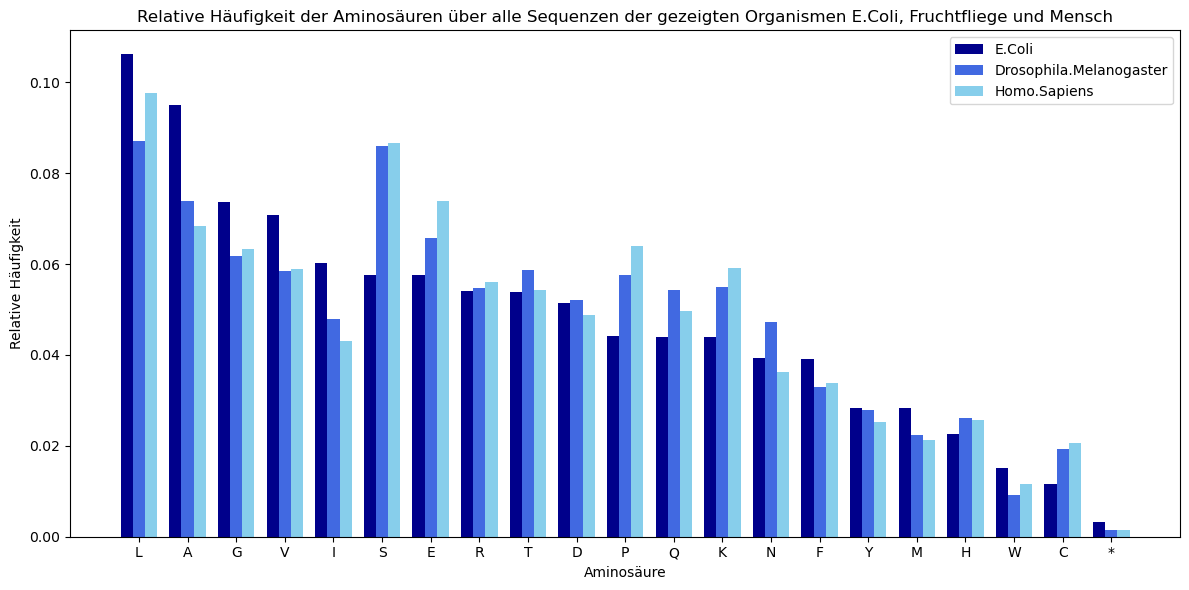

In [37]:
plot_relative_frequency(codon_amino_acid_frequencies, organisms)

In [40]:
for organism in organisms:
    relative_frequency = relative_frequencies[organism]
    avg_amino_acids = 0
    for amino_acid in relative_frequency:
        if amino_acid == 'X':
            continue
        avg_amino_acids += relative_frequency[amino_acid] * len(amino_acids_to_codons[amino_acid])
    print(f"Average number of codons per amino acid in {organism}: {avg_amino_acids}")

Average number of codons per amino acid in E.Coli: 3.5667295361502327
Average number of codons per amino acid in Drosophila.Melanogaster: 3.55016616318638
Average number of codons per amino acid in Homo.Sapiens: 3.591287276706698


## Baseline Klassifikator mit ungewichtetem Zufall

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = \frac{1}{len(C\{a\})}
$

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [7]:
calc_error_rates = {
    "Unweighted": {},
    "Weighted": {},
    "Max": {}
}

In [8]:
for organism in organisms:
    accuracy = 0
    for amino_acid in amino_acids_to_codons.keys():
        for codon in amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon]
            codon_probability = 1 / len(amino_acids_to_codons[amino_acid])
            accuracy += codon_portion * codon_probability
    accuracy /= codon_amino_acid_frequencies[organism]['total']
    error_rate = 1 - accuracy
    calc_error_rates["Unweighted"][organism] = error_rate
    print(f"Organismus {organism} - Error Rate: {error_rate}")

Organismus E.Coli - Error Rate: 0.6459047648494685
Organismus Drosophila.Melanogaster - Error Rate: 0.6460488339371624
Organismus Homo.Sapiens - Error Rate: 0.6484010513838808


### Error Rates experimentell bestimmen

In [78]:
exp_error_rates = {
    "Unweighted": {},
    "Weighted": {},
    "Max": {}
}

In [15]:
pred_codons = {}
def test_classifier(classifier, organism):
    global pred_codons
    amino_seq = dfs[organism]['translation'].apply(lambda seq: list(seq))
    pred_codons = classifier.predict_codons(amino_seq)
    true_codons = dfs[organism]['codons']
    error_rate = classifier.calc_error_rate(true_codons, pred_codons)
    #error_rate_per_amino_acid = classifier.calc_amino_acid_error_rate(amino_seq, true_codons, pred_codons)
    print(f"Organismus {organism} - Error Rate: {error_rate}")
    #print("Error Rates pro Aminosäure:")
    #print(error_rate_per_amino_acid)
    return error_rate#, error_rate_per_amino_acid

In [16]:
%%time
print("Ungewichteter Baseline Klassifikator")
for organism in organisms[2:]:
    start_time = time.time()
    seed = 42
    unweighted_bc = bc.Unweighted_Baseline_Classifier(seed)
    error_rate = test_classifier(unweighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_error_rates["Unweighted"][organism] = error_rate 

Ungewichteter Baseline Klassifikator
Organismus Homo.Sapiens - Error Rate: 0.6480132960836085
154.54
CPU times: total: 2min 32s
Wall time: 2min 34s


In [31]:
#mlh.to_pickle(exp_error_rates, "../data/baseline_classifier_error_rates.pkl")

## Baseline Klassifikator mit Usage Bias gewichtetem Zufall

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = CUB_{c\{a\}}
$

$CUB_{c\{a\}}$: Codon Usage Bias für Codon c\{a\} für den betrachteten Organismus

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [9]:
for organism in organisms:
    accuracy = 0
    for amino_acid in amino_acids_to_codons.keys():
        for codon in amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon] / codon_amino_acid_frequencies[organism]['total']
            codon_probability = usage_biases[organism][amino_acid][codon]
            accuracy += codon_portion * codon_probability
    error_rate = 1 - accuracy
    calc_error_rates["Weighted"][organism] = error_rate
    print(f"Organismus {organism} - Error Rate: {error_rate}")

Organismus E.Coli - Error Rate: 0.5826873340938544
Organismus Drosophila.Melanogaster - Error Rate: 0.6053528291892591
Organismus Homo.Sapiens - Error Rate: 0.6231533957311384


### Error Rates experimentell bestimmen

In [24]:
%%time
print("Usage Bias Gewichteter Baseline Klassifikator")
for organism in organisms[2:]:
    start_time = time.time()
    seed = 42
    weighted_bc = bc.Bias_Weighted_Classifier(usage_biases[organism], seed)
    error_rate = test_classifier(weighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_error_rates["Weighted"][organism] = error_rate

Usage Bias Gewichteter Baseline Klassifikator
Organismus Homo.Sapiens - Error Rate: 0.6217771667057421
136.67
CPU times: total: 2min 16s
Wall time: 2min 16s


In [33]:
#mlh.to_pickle(exp_error_rates, "../data/baseline_classifier_error_rates.pkl")

## Baseline Klassifikator der immer das nach Usage Bias wahrscheinlichste Codon wählt

### Berechnung der Error Rates

$
E = 1 - Accuracy = 1 - \sum_{a \in A} \sum_{c \in C\{a\}} \frac{G_{c\{a\}}}{G_a} \times p_{c\{a\}}
$

$
p_{c\{a\}} = 
\begin{cases}
1 & CUB_{c\{a\}} = max(CUB_{C\{a\}}) \\
0 & \text{sonst}
\end{cases}
$

$CUB_{C\{a\}}$: Menge an Codon Usage Bias für alle Codons der Menge $C\{a\}$ für den betrachteten Organismus <br>

$CUB_{c\{a\}}$: Codon Usage Bias für Codon c\{a\} für den betrachteten Organismus

- $A$: Menge aller Aminosäuren
- $C\{a\}$: Menge aller Codons, welche die Aminosäure a kodieren
- $G$: Gesamtanzahl an Codons / zu klassifizierenden Aminosäuren
- $G_{c\{a\}}$: Gesamtanzahl des Vorkommens von Codon c{a}
- $p_{c\{a\}}$: Von Klassifikator angenommene Wahrscheinlichkeit,<br>dass Aminosäure a durch Codon $c\{a\}$ kodiert wird

In [10]:
for organism in organisms:
    accuracy = 0
    for amino_acid in amino_acids_to_codons.keys():
        codon_probs = usage_biases[organism][amino_acid]
        highest_prob_codon = max(codon_probs, key=codon_probs.get)
        for codon in amino_acids_to_codons[amino_acid]:
            codon_portion = codon_amino_acid_frequencies[organism][amino_acid][codon] / codon_amino_acid_frequencies[organism]['total']
            accuracy += codon_probs[highest_prob_codon] * codon_portion
    error_rate = 1 - accuracy
    calc_error_rates["Max"][organism] = error_rate
    print(f"Organismus {organism} - Error Rate: {error_rate}")

Organismus E.Coli - Error Rate: 0.4815799655540969
Organismus Drosophila.Melanogaster - Error Rate: 0.5084628229069861
Organismus Homo.Sapiens - Error Rate: 0.5646545466045912


### Error Rates experimentell bestimmen

In [28]:
%%time
print("Usage Bias Maximum Baseline Klassifikator")
for organism in organisms[2:]:
    start_time = time.time()
    seed = 42
    max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases[organism], seed)
    error_rate = test_classifier(max_weighted_bc, organism)
    print(round(time.time() - start_time, 2))
    exp_error_rates["Max"][organism] = error_rate

Usage Bias Maximum Baseline Klassifikator
Organismus Homo.Sapiens - Error Rate: 0.5558527019957237
97.02
CPU times: total: 1min 34s
Wall time: 1min 37s


### Accuracy in Segmenten

#### Testdaten laden

In [5]:
organisms = ["E.Coli", "Drosophila.Melanogaster", "Homo.Sapiens"]

dfs = {}
usage_biases = {}

def group_codons(sequence):
    return [''.join(sequence[i:i+3]) for i in range(0, len(sequence), 3)]

for organism in organisms:
    dfs[organism] = pd.read_pickle(f"../data/{organism}/cleanedData_test.pkl")
    dfs[organism]['codons'] = dfs[organism]['sequence'].apply(group_codons)
    usage_biases[organism] = pd.read_pickle(f"../data/{organism}/usageBias.pkl")

#### Codon Prediction mit Max CUB

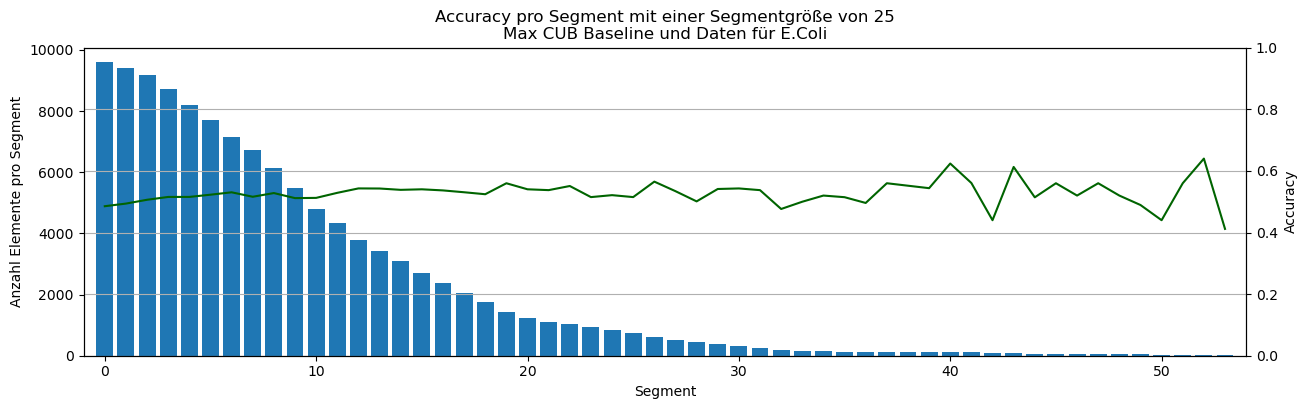

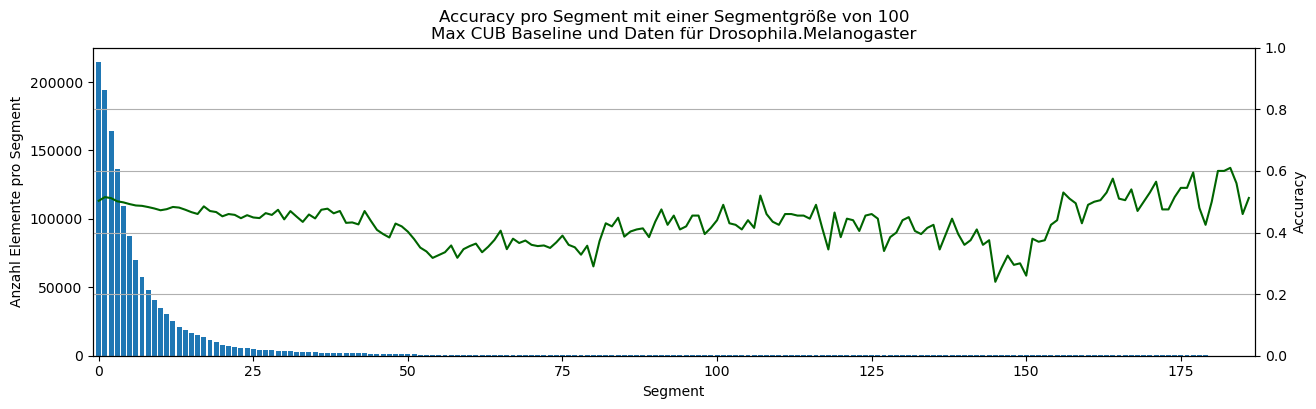

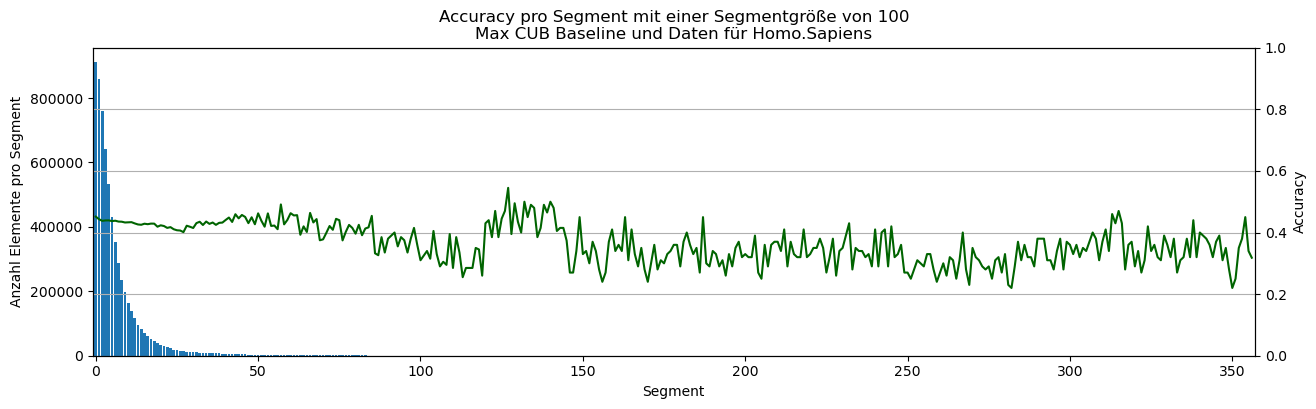

In [41]:
for (organism, segment_size) in [("E.Coli", 25), ("Drosophila.Melanogaster", 100), ("Homo.Sapiens", 100)]:
    max_weighted_bc = bc.Max_Bias_Baseline_Classifier(usage_biases[organism])
    amino_seq = dfs[organism]['translation'].apply(lambda seq: list(seq))
    pred_codons = max_weighted_bc.predict_codons(amino_seq)
    true_codons = list(dfs[organism]['codons'])
    preds = []
    for codon_seq in pred_codons:
        preds.append(list(codon_seq[codon_seq != '']))

    seg_acc, seg_el = max_weighted_bc.calc_accuracy_per_segment(true_codons, preds, segment_size=segment_size)
    mle.plot_accuracies_per_segment(seg_acc, seg_el, f"Accuracy pro Segment mit einer Segmentgröße von {segment_size}\nMax CUB Baseline und Daten für {organism}")

## Visualisierung der berechneten und experimentell bestimmten Error Rates

In [11]:
calc_error_rates

{'Unweighted': {'E.Coli': 0.6459047648494685,
  'Drosophila.Melanogaster': 0.6460488339371624,
  'Homo.Sapiens': 0.6484010513838808},
 'Weighted': {'E.Coli': 0.5826873340938544,
  'Drosophila.Melanogaster': 0.6053528291892591,
  'Homo.Sapiens': 0.6231533957311384},
 'Max': {'E.Coli': 0.4815799655540969,
  'Drosophila.Melanogaster': 0.5084628229069861,
  'Homo.Sapiens': 0.5646545466045912}}

In [12]:
exp_error_rates = mlh.from_pickle("../data/baseline_classifier_error_rates.pkl")
exp_error_rates

{'Unweighted': {'E.Coli': 0.6457996806107671,
  'Drosophila.Melanogaster': 0.6463610382387691,
  'Homo.Sapiens': 0.6480132960836085},
 'Weighted': {'E.Coli': 0.5833700327328002,
  'Drosophila.Melanogaster': 0.6052259330501663,
  'Homo.Sapiens': 0.6217771667057421},
 'Max': {'E.Coli': 0.4815799655540969,
  'Drosophila.Melanogaster': 0.5084628229069863,
  'Homo.Sapiens': 0.5558527019957237}}

In [28]:
# Calculating average error rates for each classifier
average_error_rates = {classifier: np.mean(list(error_rates.values())) for classifier, error_rates in calc_error_rates.items()}
average_error_rates

{'Unweighted': 0.6467848833901706,
 'Weighted': 0.603731186338084,
 'Max': 0.5182324450218915}

In [21]:
classifier_names = {
    "Unweighted": "Ungewichteten Baseline Klassifikator",
    "Weighted": "Usage Bias Gewichteten Baseline Klassifikator",
    "Max": "Usage Bias Maximum Baseline Klassifikator"
}

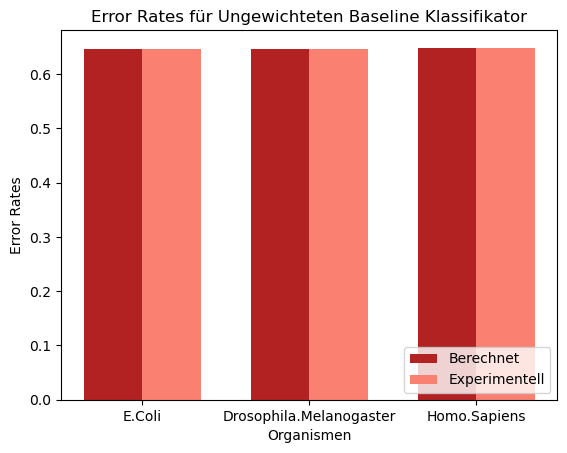

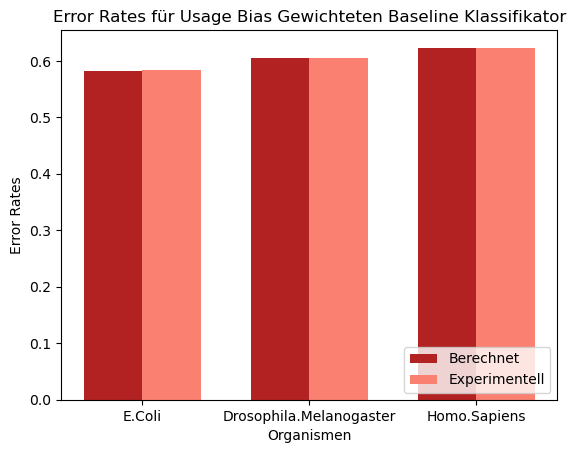

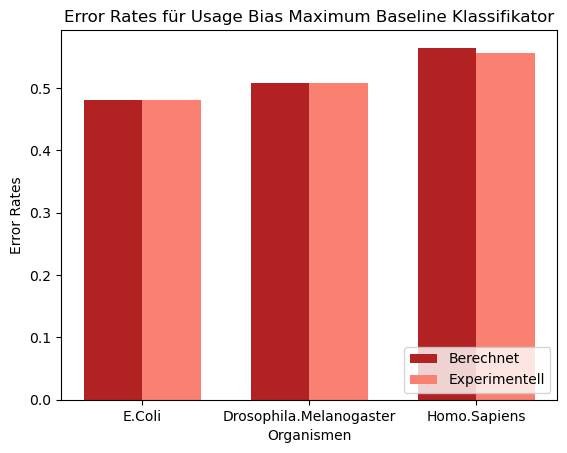

In [24]:
classifiers = list(calc_error_rates.keys())

bar_width = 0.35
index = np.arange(len(organisms))

for classifier in classifiers:
    calc_rates = [calc_error_rates[classifier][organism] for organism in organisms]
    exp_rates = [exp_error_rates[classifier][organism] for organism in organisms]

    fig, ax = plt.subplots()

    ax.bar(index, calc_rates, bar_width, label='Berechnet', color='firebrick')
    ax.bar(index + bar_width, exp_rates, bar_width, label='Experimentell', color='salmon')

    ax.set_xlabel('Organismen')
    ax.set_ylabel('Error Rates')
    ax.set_title(f'Error Rates für {classifier_names[classifier]}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(organisms)
    ax.legend(loc='lower right')

    plt.show()

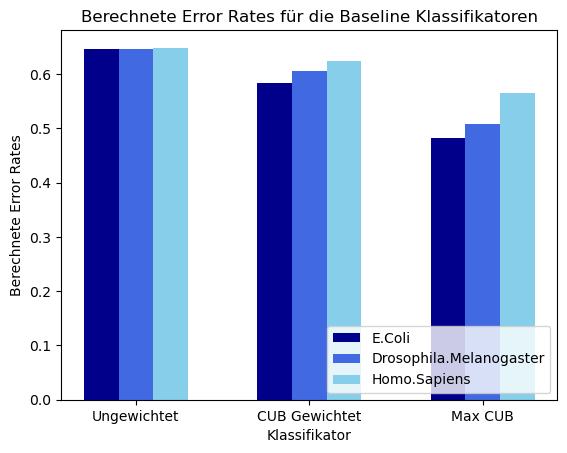

In [27]:
classifiers = list(calc_error_rates.keys())

# Colors for each organism
colors = ['darkblue', '#4169e1', 'skyblue']

# Plotting
bar_width = 0.2
index = np.arange(len(classifiers))

fig, ax = plt.subplots()

for i, organism in enumerate(organisms):
    error_rates = [calc_error_rates[classifier][organism] for classifier in classifiers]
    ax.bar(index + i * bar_width, error_rates, bar_width, label=organism, color=colors[i])

ax.set_xlabel('Klassifikator')
ax.set_ylabel('Berechnete Error Rates')
ax.set_title('Berechnete Error Rates für die Baseline Klassifikatoren')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(['Ungewichtet', 'CUB Gewichtet', 'Max CUB'])
ax.legend(loc='lower right')

plt.show()